In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn
from aisynphys.database import default_db
import aisynphys.pipeline.multipatch.conductance as conductance_pipeline

In [2]:
db = default_db
session = db.session()

Select a synapse to analyze

In [37]:
# syn = db.pair_query(synapse=True, synapse_type='in', session=session)
# example_pair = syn[3]

# inhibitory
# example_pair = db.pair_from_ext_id('1614212743.568', '6', '4')

# excitatory w/ failures, crosstalk
example_pair = db.pair_from_ext_id('1625092356.185', '6', '7')

# example_pair = db.pair_from_ext_id('1596739041.999 1 6')

print(f"Selected {example_pair.synapse.synapse_type} pair {example_pair}")

psc_sign = {'in': -1, 'ex': 1}[example_pair.synapse.synapse_type]

Selected ex pair <Pair 1625092356.185 6 7>


Load VC data for this synapse

In [38]:
vc_data = conductance_pipeline.get_raw_vc_data(example_pair, db, session)
if vc_data['error'] is not None:
    print(f"Error loading data: {vc_data['error']}")
    adj_holding = None
    amps = None
else:
    adj_holding = vc_data['adj_baseline']
    amps = vc_data['pr_amps']

Plot the raw data we are working with 

Text(0.5, 0, 'Time (ms)')

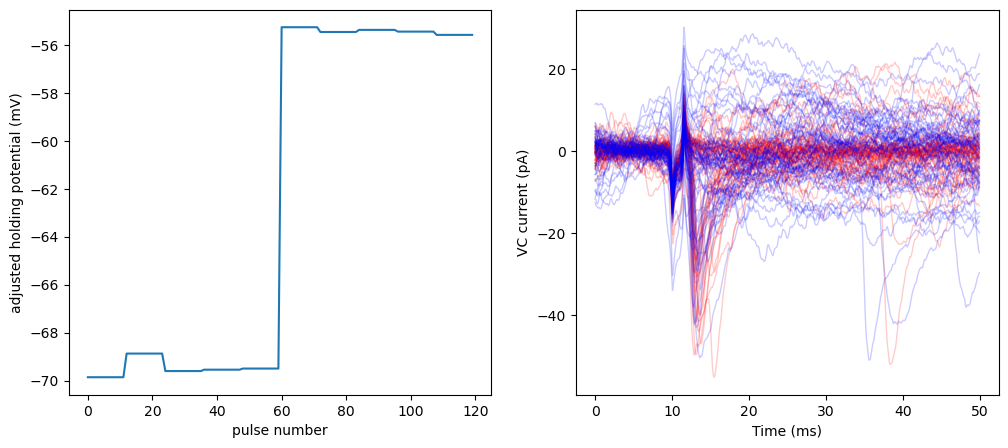

In [39]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].plot(adj_holding * 1e3)
ax[0].set_ylabel('adjusted holding potential (mV)')
ax[0].set_xlabel('pulse number')

from neuroanalysis.filter import bessel_filter
prs = vc_data['pulse_responses']
for pr in prs:
    ts = bessel_filter(pr.post_tseries.copy(), cutoff=2e3)
    ts.t0 = 0
    baseline = ts.time_slice(0, 10e-3).data.mean()
    holding = pr.recording.patch_clamp_recording.access_adj_baseline_potential
    amp = pr.pulse_response_fit.fit_amp
    color = 'red' if holding < -60e-3 else 'blue'
    ax[1].plot(ts.time_values * 1e3, (ts.data - baseline) * 1e12, alpha=0.2, color=color, linewidth=1)
ax[1].set_ylabel('VC current (pA)')
ax[1].set_xlabel('Time (ms)')

Estimate the conductance and reversal potential 

Estimated conductance: 0.13+/-0.19 nS
Estimated reversal: 21.36+/-126.15 mV
Fit R^2: 0.0037530094588720253


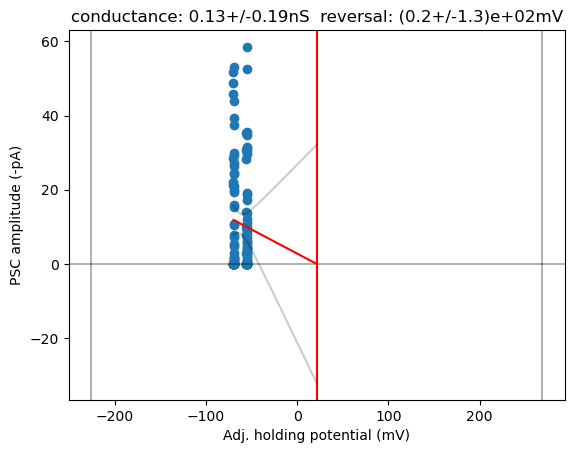

In [40]:

# plot PSC amplitudes first
fig, ax = plt.subplots()
ax.scatter(adj_holding * 1e3, amps * -1e12)
ax.set_xlabel('Adj. holding potential (mV)')
ax.set_ylabel('PSC amplitude (-pA)')

# calculate conductance and reversal potential
conductance, reversal, r2 = conductance_pipeline.calculate_conductance(amps, adj_holding, syn_type=example_pair.synapse.synapse_type)

print(f"Estimated conductance: {conductance*1e9:0.2f} nS")
print(f"Estimated reversal: {reversal*1e3:0.2f} mV")
print(f"Fit R^2: {r2}")

# plot conductance and reversal with CIs
ci_x = np.linspace(min(reversal.n, adj_holding.min()), max(reversal.n, adj_holding.max()), 100)
ci_y = conductance_pipeline.ipsc_amp_fn(ci_x, conductance, reversal)
nom = np.array([x.n for x in ci_y])
std = np.array([x.s for x in ci_y])
upper_ci = nom + 1.96 * std
lower_ci = nom - 1.96 * std

ax.set_title(f'conductance: {conductance*1e9}nS  reversal: {reversal*1e3}mV')
ax.axvline(reversal.n * 1e3, color='red')
ax.axvline((reversal.n + 1.96 * reversal.s) * 1e3, color=(0, 0, 0, 0.3))
ax.axvline((reversal.n - 1.96 * reversal.s) * 1e3, color=(0, 0, 0, 0.3))
ax.axhline(0, color=(0, 0, 0, 0.3))

ax.plot(ci_x * 1e3, nom * -1e12, color='red')
ax.plot(ci_x * 1e3, upper_ci * -1e12, color=(0, 0, 0, 0.2))
ax.plot(ci_x * 1e3, lower_ci * -1e12, color=(0, 0, 0, 0.2))


Load conductance results from all synapses (where available)

In [33]:
import pandas
cond_df = db.query(
    db.Conductance.effective_conductance, 
    db.Conductance.reversal_potential,
    db.Conductance.meta,
    db.Synapse.synapse_type,
).join(db.Synapse).dataframe()

# unpack meta column:
meta = pandas.DataFrame.from_records(cond_df['conductance.meta'])
cond_df = pandas.concat([cond_df, meta], axis=1)
cond_df

,conductance.effective_conductance,conductance.reversal_potential,conductance.meta,synapse.synapse_type,reversal_std,conductance_std,fit_r_squared
0,-4.330930e-10,-0.080441,"{'reversal_std': 0.004091654073080157, 'conduc...",ex,0.004092,8.085453e-11,0.138813
1,3.187801e-11,0.062163,"{'reversal_std': 0.31404023576276757, 'conduct...",ex,0.314040,8.065046e-11,0.001322
2,1.686575e-10,-0.000112,"{'reversal_std': 0.06405107155263852, 'conduct...",ex,0.064051,1.676046e-10,0.009642
3,-8.018014e-11,-0.213370,"{'reversal_std': 0.34889085386361346, 'conduct...",ex,0.348891,1.801170e-10,0.001100
4,1.257645e-09,-0.064559,"{'reversal_std': 0.000519331308850021, 'conduc...",in,0.000519,7.924225e-11,0.540659
...,...,...,...,...,...,...,...
1450,2.262249e-11,0.098241,"{'reversal_std': 0.4924606100052645, 'conducta...",ex,0.492461,6.949187e-11,0.000495
1451,9.016382e-11,0.031665,"{'reversal_std': 0.15915693063837363, 'conduct...",ex,0.159157,1.494820e-10,0.003897
1452,-1.677629e-10,-0.098998,"{'reversal_std': 0.03626856723647999, 'conduct...",ex,0.036269,1.594765e-10,0.009291
1453,-7.483589e-11,-0.142969,"{'reversal_std': 0.15163285020484824, 'conduct...",ex,0.151633,1.438150e-10,0.001519


(array([  1.,   1.,   2.,   1.,   2.,  10.,  34.,  79., 170., 176., 135.,
         47.,  32.,  18.,  10.,  11.,   4.,   2.,   0.]),
 array([-0.09      , -0.08789474, -0.08578947, -0.08368421, -0.08157895,
        -0.07947368, -0.07736842, -0.07526316, -0.07315789, -0.07105263,
        -0.06894737, -0.06684211, -0.06473684, -0.06263158, -0.06052632,
        -0.05842105, -0.05631579, -0.05421053, -0.05210526, -0.05      ]),
 <BarContainer object of 19 artists>)

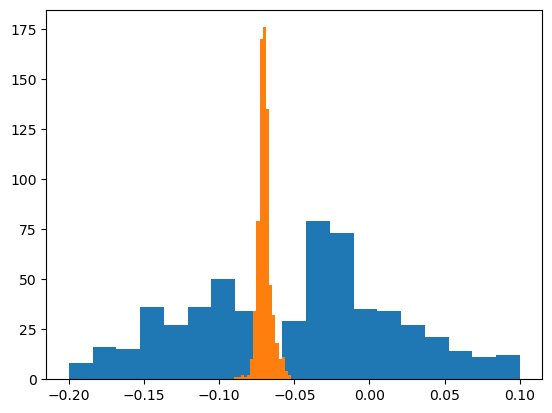

In [48]:
fig, ax = plt.subplots()
ax.hist(cond_df[cond_df['synapse.synapse_type']=='ex']['conductance.reversal_potential'], bins=np.linspace(-200e-3, 100e-3, 20))
ax.hist(cond_df[cond_df['synapse.synapse_type']=='in']['conductance.reversal_potential'], bins=np.linspace(-90e-3, -50e-3, 20))



In [41]:

# filter on fit R^2
filtered = cond_df[cond_df['fit_r_squared'] > 0.5]
filtered

,conductance.effective_conductance,conductance.reversal_potential,conductance.meta,synapse.synapse_type,reversal_std,conductance_std,fit_r_squared
4,1.257645e-09,-0.064559,"{'reversal_std': 0.000519331308850021, 'conduc...",in,0.000519,7.924225e-11,0.540659
23,9.603176e-10,-0.073886,"{'reversal_std': 0.0006505107297746662, 'condu...",in,0.000651,4.813637e-11,0.663333
27,6.898519e-10,-0.070572,"{'reversal_std': 0.0007119026364475313, 'condu...",in,0.000712,4.678727e-11,0.648180
32,6.367097e-10,-0.063882,"{'reversal_std': 0.0005802706129227907, 'condu...",in,0.000580,5.275235e-11,0.552488
41,6.429835e-10,-0.067686,"{'reversal_std': 0.0006399117474069737, 'condu...",in,0.000640,5.050906e-11,0.582816
...,...,...,...,...,...,...,...
1381,4.121480e-10,-0.070796,"{'reversal_std': 0.0005380465293495868, 'condu...",in,0.000538,2.659461e-11,0.584114
1397,6.470281e-10,-0.073016,"{'reversal_std': 0.0007908328604777729, 'condu...",in,0.000791,4.671846e-11,0.619120
1404,3.616996e-10,-0.072069,"{'reversal_std': 0.0006841303669589757, 'condu...",in,0.000684,2.573866e-11,0.525941
1409,6.391279e-10,-0.068604,"{'reversal_std': 0.0003077794646903019, 'condu...",in,0.000308,3.047544e-11,0.729604


In [36]:
seaborn.scatterplot(data=filtered, x='conductance.reversal_potential', y='conductance.effective_conductance', hue='synapse_synapse_type')

ValueError: Could not interpret value `synapse_synapse_type` for parameter `hue`